<a href="https://colab.research.google.com/github/Asekseria/Predicting-News-Category/blob/master/machine_hack_news_prediction_XLNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### News Category Classification

The dataset has news categories (political,Technology,Entertainment,Business) and story related to the category.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import classification_report
import torch
import torch.nn.functional as F
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
n_gpu

1

In [0]:
df=pd.read_excel('/content/gdrive/My Drive/Predicting_News_Category/Data_Train.xlsx')

In [6]:
df.describe()

,SECTION
count,7628.000000
mean,1.357892
std,0.999341
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,3.000000


In [7]:
df.columns

Index(['STORY', 'SECTION'], dtype='object')

In [8]:
df.groupby('SECTION').count()#0:political,1:Technology,2:Entertainment,3:Business

,STORY
SECTION,
0,1686
1,2772
2,1924
3,1246


In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
stopword= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:

from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_text = []
# tqdm is for printing the status bar
for sentance in tqdm(df['STORY'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)

    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopword)
    preprocessed_text.append(sentance.strip())

100%|██████████| 7628/7628 [00:03<00:00, 2130.42it/s]


In [0]:
final=df.drop(['STORY'],axis=1)
final['story']=np.array(preprocessed_text)

In [14]:
final.head()

,SECTION,story
0,3,painful huge reversal fee income unheard among...
1,0,formidable opposition alliance among congress ...
2,3,asian currencies trading lower today south kor...
3,1,want answer question click answer clicking ans...
4,3,global markets gold prices edged today disappo...


In [15]:
final.columns

Index(['SECTION', 'story'], dtype='object')

In [16]:
!pip install transformers

     |████████████████████████████████| 665kB 2.6MB/s 
     |████████████████████████████████| 890kB 6.6MB/s 
     |████████████████████████████████| 1.1MB 11.6MB/s 
     |████████████████████████████████| 3.8MB 16.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=5301a3ad7a006c15a094317d944f5cfc32c3e3db46d816abcaf135da337c2631
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
from transformers import (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer)

In [18]:
df_data=final.rename(columns={"SECTION":"labels","story":"texts"})
df_data.head()

,labels,texts
0,3,painful huge reversal fee income unheard among...
1,0,formidable opposition alliance among congress ...
2,3,asian currencies trading lower today south kor...
3,1,want answer question click answer clicking ans...
4,3,global markets gold prices edged today disappo...


In [19]:
sentences = df_data.texts.to_list()
sentences[0]

'painful huge reversal fee income unheard among private sector lenders essentially means yes bank took granted fees structured loan deals paid accounted upfront books borrowers turned defaulters fees tied loan deals fell cracks gill vowed shift safer accounting practice amortizing fee income rather booking upfront gill move mend past ways means no nasty surprises future good news considering investors love clean image loathe uncertainties no gain without pain promise strong stable balance sheet comes sacrifices well investors give hopes phenomenal growth promise made kapoor'

In [20]:
labels = df_data.labels.to_list()
print(labels[0])

3


In [21]:
df_data.labels.unique()

array([3, 0, 1, 2])

In [0]:
tag2idx={'0': 0,'1': 1,'2':2,'3':3}

In [23]:
tag2name={tag2idx[key] : key for key in tag2idx.keys()}
tag2name

{0: '0', 1: '1', 2: '2', 3: '3'}

In [24]:
os.path.exists('/content/gdrive/My Drive/Predicting_News_Category/model/xlnet_base_cased_spiece.model')

True

In [0]:
vocabulary = '/content/gdrive/My Drive/Predicting_News_Category/model/xlnet_base_cased_spiece.model'
max_len=64
tokenizer = XLNetTokenizer(vocab_file=vocabulary,do_lower_case=False)

In [26]:

full_input_ids = []
full_input_masks = []
full_segment_ids = []

SEG_ID_A   = 0
SEG_ID_B   = 1
SEG_ID_CLS = 2
SEG_ID_SEP = 3
SEG_ID_PAD = 4

UNK_ID = tokenizer.encode("<unk>")[0]
CLS_ID = tokenizer.encode("<cls>")[0]
SEP_ID = tokenizer.encode("<sep>")[0]
MASK_ID = tokenizer.encode("<mask>")[0]
EOD_ID = tokenizer.encode("<eod>")[0]

for i,sentence in enumerate(sentences):
    # Tokenize sentence to token id list
    tokens_a = tokenizer.encode(sentence)
    
    # Trim the len of text
    if(len(tokens_a)>max_len-2):
        tokens_a = tokens_a[:max_len-2]
        
        
    tokens = []
    segment_ids = []
    
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(SEG_ID_A)
        
    # Add <sep> token 
    tokens.append(SEP_ID)
    segment_ids.append(SEG_ID_A)
    
    
    # Add <cls> token
    tokens.append(CLS_ID)
    segment_ids.append(SEG_ID_CLS)
    
    input_ids = tokens
    
    # The mask has 0 for real tokens and 1 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [0] * len(input_ids)

    # Zero-pad up to the sequence length at fornt
    if len(input_ids) < max_len:
        delta_len = max_len - len(input_ids)
        input_ids = [0] * delta_len + input_ids
        input_mask = [1] * delta_len + input_mask
        segment_ids = [SEG_ID_PAD] * delta_len + segment_ids

    assert len(input_ids) == max_len
    assert len(input_mask) == max_len
    assert len(segment_ids) == max_len
    
    full_input_ids.append(input_ids)
    full_input_masks.append(input_mask)
    full_segment_ids.append(segment_ids)
    
    if 3 > i:
        print("No.:%d"%(i))
        print("sentence: %s"%(sentence))
        print("input_ids:%s"%(input_ids))
        print("attention_masks:%s"%(input_mask))
        print("segment_ids:%s"%(segment_ids))
        print("\n")

No.:0
sentence: painful huge reversal fee income unheard among private sector lenders essentially means yes bank took granted fees structured loan deals paid accounted upfront books borrowers turned defaulters fees tied loan deals fell cracks gill vowed shift safer accounting practice amortizing fee income rather booking upfront gill move mend past ways means no nasty surprises future good news considering investors love clean image loathe uncertainties no gain without pain promise strong stable balance sheet comes sacrifices well investors give hopes phenomenal growth promise made kapoor
input_ids:[7654, 1519, 20391, 3336, 1378, 29136, 447, 804, 1967, 8886, 6584, 731, 4336, 1013, 288, 3445, 3407, 14107, 1361, 4108, 1373, 12141, 76, 6731, 1345, 17585, 711, 5327, 270, 3407, 3694, 1361, 4108, 865, 17647, 17, 19200, 7044, 3961, 11360, 5701, 1211, 24, 11152, 2577, 3336, 1378, 870, 10101, 76, 6731, 17, 19200, 579, 416, 66, 396, 1420, 731, 116, 14527, 2808, 7739, 7739]
attention_masks:[0, 0,

In [27]:
tags = [tag2idx[str(lab)] for lab in labels]
print(tags[0])

3


In [0]:
tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(full_input_ids, tags,full_input_masks,full_segment_ids, 
                                                            random_state=4, test_size=0.3)


In [29]:
len(tr_inputs),len(val_inputs),len(tr_segs),len(val_segs)

(5339, 2289, 5339, 2289)

In [30]:
device

device(type='cuda')

In [0]:
tr_inputs = torch.tensor(tr_inputs).to(device)
val_inputs = torch.tensor(val_inputs).to(device)
tr_tags = torch.tensor(tr_tags).to(device)
val_tags = torch.tensor(val_tags).to(device)
tr_masks = torch.tensor(tr_masks).to(device)
val_masks = torch.tensor(val_masks).to(device)
tr_segs = torch.tensor(tr_segs).to(device)
val_segs = torch.tensor(val_segs).to(device)

In [0]:
# Set batch num
batch_num = 32

In [0]:
# Set token embedding, attention embedding, segment embedding
train_data = TensorDataset(tr_inputs, tr_masks,tr_segs, tr_tags)
train_sampler = RandomSampler(train_data)
# Drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks,val_segs, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

In [34]:
path= '/content/gdrive/My Drive/Predicting_News_Category/model'
if os.path.exists(path) !=True: 
    os.makedirs(path) 
    print("Directory created successfully") 
else:
  print('Directory already there')

Directory already there


In [0]:
model_file_address = '/content/gdrive/My Drive/Predicting_News_Category/model/'

In [0]:
model = XLNetForSequenceClassification.from_pretrained(model_file_address,num_labels=len(tag2idx))

In [0]:
model;

In [0]:
# Set epoch and grad max num
epochs = 5
max_grad_norm = 1.0

In [0]:
# Cacluate train optimiazaion num
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

In [0]:
# True: fine tuning all the layers 
# False: only fine tuning the classifier layers
# Since XLNet in 'pytorch_transformer' did not contian classifier layers
# FULL_FINETUNING = True need to set True
FULL_FINETUNING = True

In [0]:
if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)

In [0]:

# TRAIN loop
model.train();

In [44]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla P100-PCIE-16GB


In [0]:
model=model.to('cuda');

In [46]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))
for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        typ= [type(a) for a in batch]
        # print(typ)
        b_input_ids, b_input_mask, b_segs,b_labels = batch
        
        # forward pass
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        loss, logits = outputs[:2]
        # if n_gpu>1:
        #     # When multi gpu, average it
        #     loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 5339
  Batch size = 32
  Num steps = 835


Epoch:  20%|██        | 1/5 [00:49<03:19, 49.87s/it]

Train loss: 0.31343672487391044


Epoch:  40%|████      | 2/5 [01:39<02:29, 49.68s/it]

Train loss: 0.12573157589747963


Epoch:  60%|██████    | 3/5 [02:28<01:38, 49.49s/it]

Train loss: 0.08376489934253406


Epoch:  80%|████████  | 4/5 [03:17<00:49, 49.35s/it]

Train loss: 0.04695212414645287


Epoch: 100%|██████████| 5/5 [04:06<00:00, 49.22s/it]

Train loss: 0.02927184214882822


In [0]:
xlnet_out_address = '/content/gdrive/My Drive/Predicting_News_Category/model/xlnet_out_model/tc02'

In [0]:
if not os.path.exists(xlnet_out_address):
        os.makedirs(xlnet_out_address)

In [0]:
# Save a trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

In [0]:
# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(xlnet_out_address, "pytorch_model.bin")
output_config_file = os.path.join(xlnet_out_address, "config.json")

In [52]:
# Save model into file
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(xlnet_out_address)

('/content/gdrive/My Drive/Predicting_News_Category/model/xlnet_out_model/tc02/spiece.model',)

In [0]:
model = XLNetForSequenceClassification.from_pretrained(xlnet_out_address,num_labels=len(tag2idx))

In [0]:
model.to(device);

In [0]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

In [56]:
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

y_true = []
y_predict = []
print("***** Running evaluation *****")
print("  Num examples ={}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))
for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_segs,b_labels = batch
    
    with torch.no_grad():
        outputs = model(input_ids =b_input_ids,token_type_ids=b_segs, input_mask = b_input_mask,labels=b_labels)
        tmp_eval_loss, logits = outputs[:2]
    
    # Get textclassification predict result
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)
#     print(tmp_eval_accuracy)
#     print(np.argmax(logits, axis=1))
#     print(label_ids)
    
    # Save predict and real label reuslt for analyze
    for predict in np.argmax(logits, axis=1):
        y_predict.append(predict)
        
    for real_result in label_ids.tolist():
        y_true.append(real_result)

    
    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy
   
    nb_eval_steps += 1
    
    
eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / len(val_inputs)
loss = tr_loss/nb_tr_steps 
result = {'eval_loss': eval_loss,
                  'eval_accuracy': eval_accuracy,
                  'loss': loss}
report = classification_report(y_pred=np.array(y_predict),y_true=np.array(y_true))

# Save the report into file
output_eval_file = os.path.join(xlnet_out_address, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    for key in sorted(result.keys()):
        print("  %s = %s"%(key, str(result[key])))
        writer.write("%s = %s\n" % (key, str(result[key])))
        
    print(report)
    writer.write("\n\n")  
    writer.write(report)


***** Running evaluation *****
  Num examples =2289
  Batch size = 32
***** Eval results *****
  eval_accuracy = 0.9663608562691132
  eval_loss = 0.20632463574616444
  loss = 0.02927184214882822
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       530
           1       0.96      0.98      0.97       829
           2       0.98      0.96      0.97       561
           3       0.98      0.96      0.97       369

    accuracy                           0.97      2289
   macro avg       0.97      0.96      0.97      2289
weighted avg       0.97      0.97      0.97      2289



In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

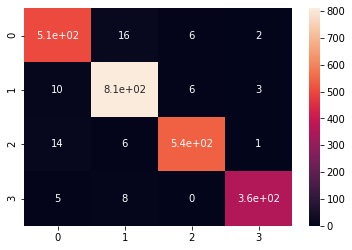

In [61]:
sns.heatmap(confusion_matrix(np.array(y_true),np.array(y_predict)),annot=True)
plt.show()